In [1]:
import os

from arcgis.features import FeatureCollection, FeatureSet
from arcgis.geometry import Geometry
import requests
from shapely import ops

In [2]:
def _get(url:str, params:dict=None)->dict:
    """
    Helper function to better handle get requests. Since everything comes back as JSON, also handles JSON body.
    :param url: String url to GET.
    :param params: Dictionary of query parameters.
    :return: Dictionary of response body JSON.
    """
    if params:
        resp = requests.get(url, params=params)
    else:
        resp = requests.get(url)

    if resp.status_code >= 200 and resp.status_code < 300:
        return resp.json()
    else:
        raise Exception(resp.content)

            
class Lookup(object):
    """
    Wrapper around lookup NLDI endpoint.
    """
    
    def __init__(self):
        self._sesh = requests.Session()
        self._sesh.headers = {'Accept': 'application/json'}
        self._root = 'https://cida.usgs.gov/nldi'

    def methods(self)->dict:
        """
        Retrieves available methods.
        """
        return _get(self._root)
    
    def comid(self, comid:[int, str])->dict:
        """
        Retrieve information about a feature by the ComID.
        """
        return _get(f'{self._root}/comid/{comid}')

    def huc12pp(self, huc12pp_id:[int, str])->dict:
        """
        Retrieve feature information by the 12 digit HUC ID.
        """
        return _get(f'{self._root}/huc12pp/{huc12pp_id}')
    
    def npdes_rad(self, npdes_rad_id):
        return _get(f'{self._root}/npdes_rad/{npdes_rad_id}')

    def nwissite(self, nwissite_id):
        return _get(f'{self._root}/nwissite/{nwissite_id}')
    
    def wqp(self, wqp_id):
        return _get(f'{self._root}/wqp/{wqp_id}')

    
class Navigate(object):
    
    def __init__(self, nav_url:str=None):
        self._sesh = requests.Session()
        self._sesh.headers = {'Accept': 'application/json'}
        self._root = nav_url
        
    def _get_navigate(self, url_suffix:str, nav_url:str=None, nav_dist_km:int=None)->dict:
        if not self._root and not nav_url:
            raise Exception('Either the Navigate object must be instantiated with the navigate '
                            'url or the navigate url must be provoded when invoking a navigate '
                            'operation.')
        elif self._root:
            nav_url = self._root
        
        nav_resp = _get(f'{nav_url}/{url_suffix}', params={'distance': nav_dist_km})
        
        return nav_resp
        
    def upstream_main(self, nav_url:str=None, nav_dist_km:int=None)->dict:
        return self._get_navigate('UM', nav_url, nav_dist_km)
    
    def upstream_tributaries(self, nav_url:str=None, nav_dist_km:int=None)->dict:
        return self._get_navigate('UT', nav_url, nav_dist_km)
    
    def downstream_main(self, nav_url:str=None, nav_dist_km:int=None)->dict:
        return self._get_navigate('DM', nav_url, nav_dist_km)
    
    def downstream_diversions(self, nav_url:str=None, nav_dist_km:int=None)->dict:
        return self._get_navigate('DD', nav_url, nav_dist_km)
    

class NLDI(object):
    
    @property
    def lookup(self):
        return Lookup()
    
    @property
    def navigate(self):
        return Navigate()
    
    @property
    def Navigate(self, nav_url:str):
        return Navigate(nav_url)

In [3]:
nldi = NLDI()

In [4]:
# get information about the site using the lookup
lookup_dict = nldi.lookup.nwissite('USGS-08279500')
lookup_dict

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'geometry': {'type': 'Point', 'coordinates': [-105.963972, 36.205556]},
   'properties': {'source': 'nwissite',
    'sourceName': 'NWIS Sites',
    'identifier': 'USGS-08279500',
    'name': 'RIO GRANDE AT EMBUDO, NM',
    'uri': 'https://waterdata.usgs.gov/nwis/inventory?agency_code=USGS&site_no=08279500',
    'comid': '17864756',
    'navigation': 'https://cida.usgs.gov/nldi/nwissite/USGS-08279500/navigate'}}]}

In [7]:
navigation_distance_km = 50

# get the navigation url from the first feature
nav_url = lookup_dict['features'][0]['properties']['navigation']

# get the downstream trace using the url from the original request
nav_dict = nldi.navigate.downstream_main(nav_url, nav_dist_km=navigation_distance_km)

# extract the geometries, the coordinate lists, from the response
geom_lst = [feat['geometry']['coordinates'] for feat in nav_dict['features']]

# combine the geometries from the responses into one geometry
downstream_linestring = ops.linemerge(geom_lst)

# convert the geometry to an esri geometry
esri_line = Geometry.from_shapely(downstream_linestring)

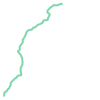

In [8]:
esri_line